
# Boston Housing

## 1. Imports

In [2]:
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
'''


from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.base import clone
from sklearn.metrics import (
    accuracy_score,
    confusion_matrix,
    f1_score,
    recall_score,
    precision_score,
    roc_auc_score,
    precision_recall_curve,
)

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from imblearn.over_sampling import SMOTE, ADASYN
from imblearn.pipeline import Pipeline as ImbPipeline


import seaborn as sns
import shap
import joblib

sns.set(style="whitegrid")
'''

'\n\n\nfrom sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold\nfrom sklearn.preprocessing import OneHotEncoder, StandardScaler\nfrom sklearn.compose import ColumnTransformer\nfrom sklearn.pipeline import Pipeline\nfrom sklearn.base import clone\nfrom sklearn.metrics import (\n    accuracy_score,\n    confusion_matrix,\n    f1_score,\n    recall_score,\n    precision_score,\n    roc_auc_score,\n    precision_recall_curve,\n)\n\nfrom sklearn.linear_model import LogisticRegression\nfrom sklearn.ensemble import RandomForestClassifier\nfrom xgboost import XGBClassifier\nfrom lightgbm import LGBMClassifier\nfrom imblearn.over_sampling import SMOTE, ADASYN\nfrom imblearn.pipeline import Pipeline as ImbPipeline\n\n\nimport seaborn as sns\nimport shap\nimport joblib\n\nsns.set(style="whitegrid")\n'

## 2. Load the Data

In [3]:

# Resolve project paths and organize outputs
PROJECT_ROOT = Path.cwd()
if not (PROJECT_ROOT / "datasets").exists() and (PROJECT_ROOT.parent / "datasets").exists():
    PROJECT_ROOT = PROJECT_ROOT.parent
if not (PROJECT_ROOT / "datasets").exists():
    raise FileNotFoundError("Could not locate datasets folder. Run from project root or src directory.")

DATA_DIR = PROJECT_ROOT / "datasets" / "boston-housing"
OUTPUT_DIR = PROJECT_ROOT / "outputs"
PLOTS_DIR = OUTPUT_DIR / "plots"
MODELS_DIR = OUTPUT_DIR / "models"
PREDICTIONS_DIR = OUTPUT_DIR / "predictions"
for path in [OUTPUT_DIR, PLOTS_DIR, MODELS_DIR, PREDICTIONS_DIR]:
    path.mkdir(parents=True, exist_ok=True)

print(f"Project root: {PROJECT_ROOT}")
print(f"Outputs directory: {OUTPUT_DIR}")


Project root: d:\学习资料\数据挖掘\data-mining
Outputs directory: d:\学习资料\数据挖掘\data-mining\outputs


In [4]:
data_path = DATA_DIR / "HousingData.csv"
df = pd.read_csv(data_path, sep=",")

Loaded 506 rows and 14 columns from d:\学习资料\数据挖掘\data-mining\datasets\boston-housing\HousingData.csv


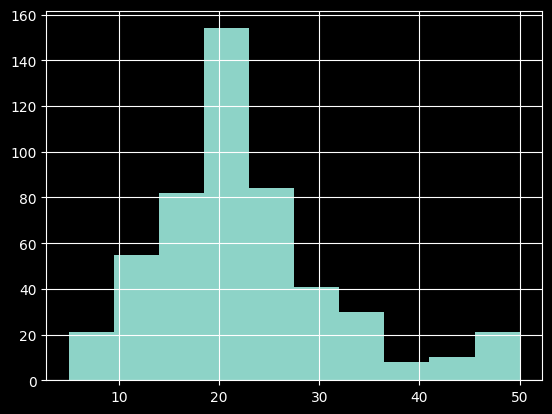

In [5]:
print(f"Loaded {df.shape[0]:,} rows and {df.shape[1]} columns from {data_path}")
df["MEDV"].hist()
plt.show()

## 3. Data Pre-processing

In [ ]:
features_list = list(df.columns)
features_list.remove('MEDV')
X = df[features_list]
Y = df['MEDV']

0      24.0
1      21.6
2      34.7
3      33.4
4      36.2
       ... 
501    22.4
502    20.6
503    23.9
504    22.0
505    11.9
Name: MEDV, Length: 506, dtype: float64

### Outliers
Relavent Parameter: Threshold = 3

Since the data size is relativly small, we impose a loose regularization on outliers.  
Among the features CHAS is actually a Boolean with only 0 and 1 values. So we do not treat it.

It is reasonable to assume that once certain features, such as crime rate, exceed a certain rate in a neighborhood, its effect on the housing price diminishes. So we will treat outliers by winsorization.

In [ ]:
features_list = list(X.columns)
features_list.remove('CHAS')
X_processed = X.copy()

for feature in features_list:
    threshold = 3

    values = X[feature]

    nan_mask = pd.isna(values)
    valid_mask = ~nan_mask
    valid_values = values[valid_mask]
    valid_indices = np.where(valid_mask)[0].tolist()
        
    Q1 = np.nanpercentile(values, 25)
    Q3 = np.nanpercentile(values, 75)
    IQR = Q3 - Q1
        
    lower_bound = Q1 - threshold * IQR
    upper_bound = Q3 + threshold * IQR
        
    outliers_mask = (valid_values < lower_bound) | (valid_values > upper_bound)
    outliers_indices = [valid_indices[i] for i in np.where(outliers_mask)[0]]

    X_processed[feature] = X_processed[feature].clip(lower=lower_bound,upper=upper_bound)

<function matplotlib.pyplot.show(close=None, block=None)>

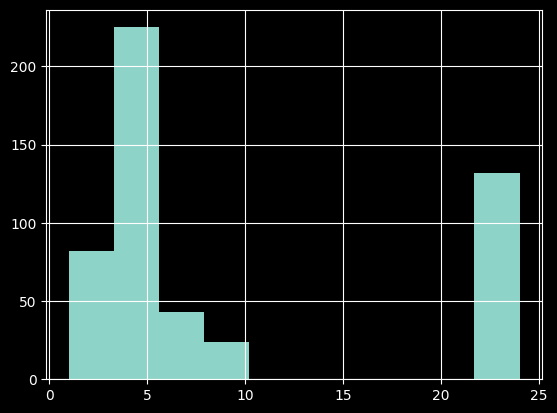

In [ ]:
X['RAD'].hist()
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

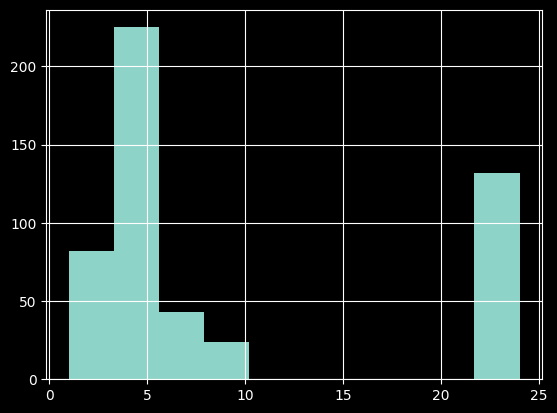

In [ ]:
X_processed['RAD'].hist()
plt.show

### Rescaling

Again, CHAS is a binary feature with only 0 and 1, so we do not rescale it

In [ ]:
n_features = list(X.columns)
n_features.remove('CHAS')

In [ ]:
from sklearn.preprocessing import StandardScaler
X_scaled = X_processed.copy()
X_processed.columns
X_nscaled = StandardScaler().fit_transform(dXprocessed[n_features])
X_scaled[n_features] = dXnscaled

X_scaled


,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
0,-0.607404,0.560859,-1.284840,0.0,-0.144217,0.413851,-0.118643,0.140214,-0.982843,-0.666608,-1.459000,0.683767,-1.082105,0.165187
1,-0.602584,-0.533952,-0.587798,0.0,-0.740262,0.194193,0.371156,0.557160,-0.867883,-0.987329,-0.303094,0.683767,-0.500165,-0.098904
2,-0.602589,-0.533952,-0.587798,0.0,-0.740262,1.283922,-0.265225,0.557160,-0.867883,-0.987329,-0.303094,0.538022,-1.215000,1.342594
3,-0.601422,-0.533952,-1.303877,0.0,-0.835284,1.017195,-0.812226,1.077737,-0.752922,-1.106115,0.113032,0.602479,-1.367479,1.199544
4,-0.592999,-0.533952,-1.303877,0.0,-0.835284,1.229721,-0.511911,1.077737,-0.752922,-1.106115,0.113032,0.683767,NaN,1.507651
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
501,-0.594473,-0.533952,0.123887,0.0,0.158124,0.439525,0.020789,-0.625796,-0.982843,-0.803212,1.176466,0.507942,NaN,-0.010873
502,-0.598460,-0.533952,0.123887,0.0,0.158124,-0.235137,0.292502,-0.716639,-0.982843,-0.803212,1.176466,0.683767,-0.508558,-0.208942
503,-0.594903,-0.533952,0.123887,0.0,0.158124,0.985816,0.803751,-0.773684,-0.982843,-0.803212,1.176466,0.683767,-0.989778,0.154184
504,-0.583690,-0.533952,0.123887,0.0,0.158124,0.726220,0.742973,-0.668437,-0.982843,-0.803212,1.176466,0.560224,-0.872271,-0.054889


### Missing Values
Relavant Parameter: k = 3; distance = eucledian

1.7% entries are missing in the dataset given

In [ ]:
X_scaled.isnull().sum().sum()/(506*14)

np.float64(0.01693958215697346)

We impute those entries using KNN, Becuase the dataset contain mostly numerical features, the dimension is not too high, and also because KNN is interpretable (for intepretable models)

In [ ]:
from sklearn.impute import KNNImputer

X_imputed = dXscaled.copy()

imputer = KNNImputer(
            n_neighbors=3,
            weights='uniform',
            metric='nan_euclidean'
        )
        
X_nimputed = imputer.fit_transform(dXscaled)
X_imputed[dXprocessed.columns] = dfXimputed
X_imputed.isnull().sum().sum()

np.int64(0)

### Multicolinearity
Relavant Parameters: threshold = 0.85, method = PCA

In [ ]:
corr_matrix = X_imputed.corr().abs()
corr_matrix

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
CRIM,1.000000,0.323858,0.587334,0.047546,0.613117,0.280982,0.493279,0.522402,0.880627,0.824075,0.400495,0.455871,0.600559,0.468219
ZN,0.323858,1.000000,0.572240,0.037020,0.546798,0.324777,0.597142,0.686890,0.334561,0.348809,0.424907,0.228458,0.437453,0.373642
INDUS,0.587334,0.572240,1.000000,0.048181,0.764827,0.391558,0.650642,0.710774,0.596755,0.721532,0.386755,0.424553,0.602470,0.489614
CHAS,0.047546,0.037020,0.048181,1.000000,0.069302,0.106883,0.085984,0.091523,0.005013,0.037834,0.109162,0.027323,0.054331,0.181635
NOX,0.613117,0.546798,0.764827,0.069302,1.000000,0.302107,0.735258,0.769230,0.611441,0.668023,0.188933,0.437429,0.588549,0.432418
RM,0.280982,0.324777,0.391558,0.106883,0.302107,1.000000,0.239055,0.205166,0.209578,0.291917,0.355671,0.194407,0.616997,0.697635
AGE,0.493279,0.597142,0.650642,0.085984,0.735258,0.239055,1.000000,0.748823,0.457379,0.510021,0.260127,0.326741,0.600397,0.381631
DIS,0.522402,0.686890,0.710774,0.091523,0.769230,0.205166,0.748823,1.000000,0.494588,0.534432,0.232471,0.322909,0.495350,0.254835
RAD,0.880627,0.334561,0.596755,0.005013,0.611441,0.209578,0.457379,0.494588,1.000000,0.910228,0.464741,0.421069,0.486088,0.386298
TAX,0.824075,0.348809,0.721532,0.037834,0.668023,0.291917,0.510021,0.534432,0.910228,1.000000,0.460853,0.453894,0.541700,0.473864


We see that RAD, TAX, and CRIM seems to have a strong correlation, Let's use PCA to combine them as one featrue

In [ ]:
from sklearn.decomposition import PCA
X_redundant = dXimputed[['CRIM','RAD','TAX']]
pca = PCA(n_components=1)
principal_components = pca.fit_transform(X_redundant)
print(f"variance Ratio: {sum(pca.explained_variance_ratio_)}")
X_reduced = dXimputed.drop(['CRIM','RAD','TAX'], axis=1)
X_reduced['CRT_COMBO'] = StandardScaler().fit_transform(principal_components)
X_reduced

variance Ratio: 0.9145928302990662


,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,PTRATIO,B,LSTAT,MEDV,CRT_COMBO
0,0.560859,-1.284840,0.0,-0.144217,0.413851,-0.118643,0.140214,-1.459000,0.683767,-1.082105,0.165187,-0.791560
1,-0.533952,-0.587798,0.0,-0.740262,0.194193,0.371156,0.557160,-0.303094,0.683767,-0.500165,-0.098904,-0.860561
2,-0.533952,-0.587798,0.0,-0.740262,1.283922,-0.265225,0.557160,-0.303094,0.538022,-1.215000,1.342594,-0.860563
3,-0.533952,-1.303877,0.0,-0.835284,1.017195,-0.812226,1.077737,0.113032,0.602479,-1.367479,1.199544,-0.860650
4,-0.533952,-1.303877,0.0,-0.835284,1.229721,-0.511911,1.077737,0.113032,0.683767,-1.210803,1.507651,-0.857758
...,...,...,...,...,...,...,...,...,...,...,...,...
501,-0.533952,0.123887,0.0,0.158124,0.439525,0.020789,-0.625796,1.176466,0.507942,-0.790202,-0.010873,-0.834587
502,-0.533952,0.123887,0.0,0.158124,-0.235137,0.292502,-0.716639,1.176466,0.683767,-0.508558,-0.208942,-0.835956
503,-0.533952,0.123887,0.0,0.158124,0.985816,0.803751,-0.773684,1.176466,0.683767,-0.989778,0.154184,-0.834734
504,-0.533952,0.123887,0.0,0.158124,0.726220,0.742973,-0.668437,1.176466,0.560224,-0.872271,-0.054889,-0.830884
